In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install pprint
!pip install uuid

from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

restartkernel()


In [78]:
import uuid
import time 
import requests
import cv2
import operator
import numpy as np
import matplotlib


import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as patches

from PIL import Image
from io import BytesIO
%matplotlib inline

import pprint 
from pprint import pprint


In [92]:
'''
@TODOS:
- import json file with env vars (base url + keys)
- apply env vars
'''

'\n@TODOS:\n\n\n'

In [79]:
'''pillow import prototype'''


def get_image(request):
    # Helper class 
    from image import Image
    if request.files:
        return Image(request.files["file"])
    else:
        return Image()

In [80]:
# Num retries for processRequest() function
_maxNumRetries = 10

In [81]:

# Primary key
_key = '' # Here, paste your primary key

#Translator key
translate_key = ''

# Key sentiment
_sentiment_key = ''

# Face API key
face_api_key = ''

In [82]:
# General headers
headers = {
    'Content-Type': 'application/json', 
    'Ocp-Apim-Subscription-Key': _key
    }

In [83]:
# Endpoint dictionaries

# Cognitive API for Computer Vision
analyze_dict = {'computer_vision_API': 
                 [{'url': 'https://maddogtest.cognitiveservices.azure.com/' + '/vision/v3.0/analyze', 
                  '_key': _key,
                  'headers': headers,
                  'params': {'visualFeatures': 'Categories,Description,Color'}}]}


# Custom Vision API - Object Detection
detect_dict = {'object_detection_API': 
                 [{'url': 'https://maddogtest.cognitiveservices.azure.com/' + 'vision/v3.0/detect' , 
                  '_key': _key,
                  'headers': headers,
                  'params': {'visualFeatures': 'Objects,Description'}}]}

                 
# OCR API 
text_recognition_dict = {'text_recognition_API': 
                 [{'url': 'https://maddogtest.cognitiveservices.azure.com/' + '/vision/v3.0/read/analyze', 
                  '_key': _key,
                  'headers': headers}]}


# Cognitive API for Translator Text 
translator_dict = {'translator_text_API': 
                 [{'url': 'https://api.cognitive.microsofttranslator.com/' + '/translate?api-version=3.0', 
                  '_key': translate_key,
                  'headers': {
                      'Content-Type': 'application/json', 
                      'Ocp-Apim-Subscription-Key': translate_key,
                      'Ocp-Apim-Subscription-Region': 'eastus',
                      'X-ClientTraceId': str(uuid.uuid4())
                      }}]}


# Cognitive API for Text Analytics
sentiment_dict = {'sentiment_analytics_API': 
                 [{'url': 'https://maddog-text-analytics.cognitiveservices.azure.com/' + '/text/analytics/v2.1/sentiment', 
                  '_key': _sentiment_key,
                   'headers': {
                      'Content-Type': 'application/json', 
                      'Ocp-Apim-Subscription-Key': _sentiment_key,
                      'Ocp-Apim-Subscription-Region': 'eastus',
                      'X-ClientTraceId': str(uuid.uuid4())
                      }}]}


# Face Detector API
face_detector_dict = {'face_detector_API': 
                 [{'url': 'https://eastus.api.cognitive.microsoft.com/face/v1.0/detect', 
                  '_key': face_api_key,
                   'headers': {'Ocp-Apim-Subscription-Key': face_api_key},
                   'params': {
                        'returnFaceId':
                        'true',
                        'returnFaceLandmarks':
                        'false',
                        'returnFaceAttributes':
                        'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise'}}]}

In [84]:
def processRequest(_url, json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:
        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:
            # print(response.json())
            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

In [85]:
# Render result on image
def render_image(result_title, image_url):

  """Display the obtained results onto the input image"""
    
  image = Image.open(BytesIO(requests.get(image_url).content))

  fig, ax = plt.subplots(figsize=(10, 15))
  ax.imshow( image )

  plt.title(result_title, fontsize=30, va="center", color='r', weight='heavy')

In [86]:
# Cognitive API for Computer Vision

# URL direction to image
analyze_image = 'https://thumbor.thedailymeal.com/QOuw1z3VzY5p7E4U2vd01ofzLk0=/870x565/https://www.theactivetimes.com/sites/default/files/2020/02/20/00_Hero.jpg'

analyze_json = {'url': analyze_image}
data = None

analyze_result = processRequest(analyze_dict['computer_vision_API'][0]['url'], 
                        analyze_json, 
                        data, 
                        analyze_dict['computer_vision_API'][0]['headers'], 
                        analyze_dict['computer_vision_API'][0]['params'] )

pprint(analyze_result['categories'][0]["detail"])

result_text = analyze_result['categories'][0]["detail"]['landmarks'][0]['name']

{'landmarks': [{'confidence': 0.9999983310699463, 'name': 'Colosseum'}]}


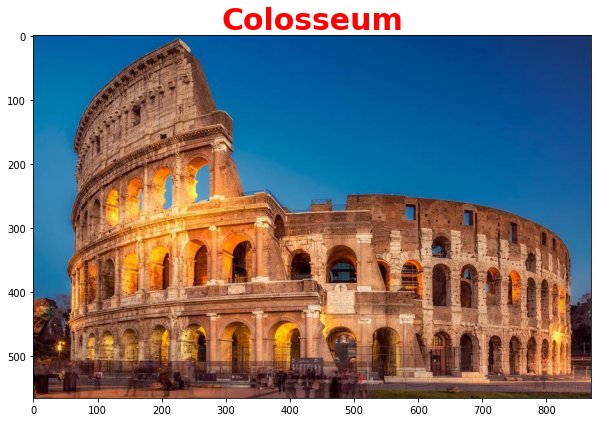

In [87]:
render_image(result_text, analyze_image)

In [88]:
# Render object on image

def render_object_detection(image_url, detection_result):
  
  image = Image.open(BytesIO(requests.get(image_url).content))
  fig, ax = plt.subplots(figsize=(10,10))

  ax.imshow(image, alpha=0.6)

  for i in detection_result['objects']:
    fr = i["rectangle"]
    fa = i["object"]
    origin = (fr["x"], fr["y"])

    rectangle = patches.Rectangle(origin, fr["w"],
                            fr["h"], fill=False, linewidth=2, color='b')
    
    ax.axes.add_patch(rectangle)
    ax.text(origin[0], origin[1], "%s"%(fa),
                fontsize=10, weight="bold", va="bottom")

    ax.axis("off")

[{'confidence': 0.501,
  'object': 'kitchen appliance',
  'rectangle': {'h': 85, 'w': 135, 'x': 730, 'y': 66}},
 {'confidence': 0.51,
  'object': 'computer keyboard',
  'rectangle': {'h': 46, 'w': 185, 'x': 523, 'y': 377}},
 {'confidence': 0.85,
  'object': 'Laptop',
  'parent': {'confidence': 0.851, 'object': 'computer'},
  'rectangle': {'h': 226, 'w': 289, 'x': 471, 'y': 218}},
 {'confidence': 0.855,
  'object': 'person',
  'rectangle': {'h': 473, 'w': 584, 'x': 654, 'y': 0}}]

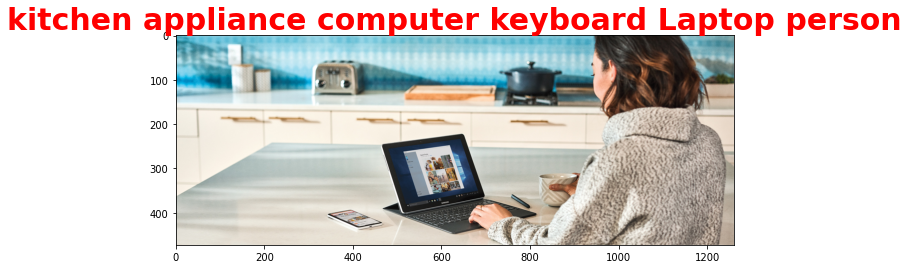

In [89]:
# Custom Vision API - Object Detection

detection_image = 'https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/images/windows-kitchen.jpg'

detect_json = { 'url': detection_image } 
data = None

detection_result = processRequest(detect_dict['object_detection_API'][0]['url'], 
                        detect_json, 
                        data, 
                        detect_dict['object_detection_API'][0]['headers'], 
                        detect_dict['object_detection_API'][0]['params'] )


detection_text_list = []
for i in detection_result['objects']:
  detection_text_list.append(i['object'])
listToStr = ' '.join([str(elem) for elem in detection_text_list]) 

render_image(listToStr, detection_image)
detection_result['objects']

In [42]:
# object_names = []
# for i in detection_result['objects']:
#   object_names.append(i['object'])
# text_to_image = str(object_names)

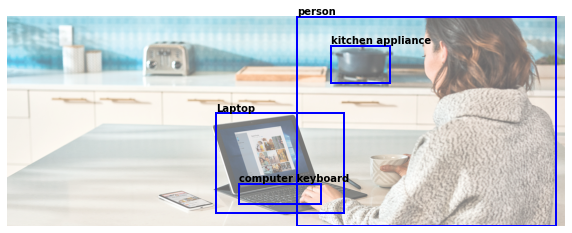

In [91]:
render_object_detection(detection_image, detection_result)


# Use Case 4: OCR Problem
Finding Text in Signboards 

In [44]:
# Text recognition function

def text_recognition(_url, headers, json, data):

  response = requests.request( 'post', _url, headers = headers, json = json, data = data)
  response.raise_for_status()

  # Holds the URI used to retrieve the recognized text.
  operation_url = response.headers["Operation-Location"]

  result = {}
  while (True):

    response_final = requests.get(
        response.headers["Operation-Location"], headers=headers)
    
    result = response_final.json()

    time.sleep(1)

    if ("analyzeResult" in result):
      break
    if ("status" in result and result['status'] == 'failed'):
      break

  return result

In [45]:
# Render image (could be replaced by opencv)
def render_text_recognition_image(result, image):
  
  polygons = []

  if ("analyzeResult" in result):
    
    # Extract the recognized text, with bounding boxes.
    polygons = [(line["boundingBox"], line["text"])
    for line in result["analyzeResult"]["readResults"][0]["lines"]]
    
  image = Image.open(BytesIO(requests.get(image_url).content))

  fig, ax = plt.subplots(figsize=(15, 20))
  ax.imshow( image )
  

  for polygon in polygons:
      vertices = [(polygon[0][i], polygon[0][i+1])
                  for i in range(0, len(polygon[0]), 2)]

      text = polygon[1]
      patch = Polygon(vertices, closed=True, fill=False, linewidth=2, color='y')
      ax.axes.add_patch(patch)
      plt.text(vertices[0][0], vertices[0][1], text, fontsize=24, va="center", color='r', weight='heavy', 
               family='monospace', rotation=25)

In [46]:
# OCR API 

# Set image_url to the URL of an image that you want to recognize.
image_url = "https://images.unsplash.com/photo-1483213097419-365e22f0f258?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80"

json = { 'url': image_url } 
data = None

# Result of text recognitioning
ocr_result = text_recognition(text_recognition_dict['text_recognition_API'][0]['url'],
                          text_recognition_dict['text_recognition_API'][0]['headers'],
                          json, 
                          data)

# Print result
pprint( ["AI description of image: ", ocr_result['analyzeResult']['readResults'][0]['lines'] ])

['AI description of image: ',
 [{'boundingBox': [322, 196, 362, 215, 358, 224, 314, 212],
   'text': 'DEPT',
   'words': [{'boundingBox': [323, 196, 362, 211, 356, 225, 317, 213],
              'confidence': 0.98,
              'text': 'DEPT'}]},
  {'boundingBox': [384, 114, 557, 195, 528, 256, 357, 170],
   'text': 'ONE',
   'words': [{'boundingBox': [393, 120, 556, 201, 528, 256, 368, 178],
              'confidence': 0.986,
              'text': 'ONE'}]},
  {'boundingBox': [372, 222, 528, 287, 524, 296, 368, 230],
   'text': 'OF TRANSPORTATION',
   'words': [{'boundingBox': [374, 223, 392, 230, 389, 239, 370, 231],
              'confidence': 0.985,
              'text': 'OF'},
             {'boundingBox': [407, 236, 526, 287, 522, 296, 404, 245],
              'confidence': 0.971,
              'text': 'TRANSPORTATION'}]},
  {'boundingBox': [600, 213, 657, 226, 646, 287, 590, 270],
   'text': 'W',
   'words': [{'boundingBox': [628, 217, 658, 226, 644, 286, 612, 277],
              

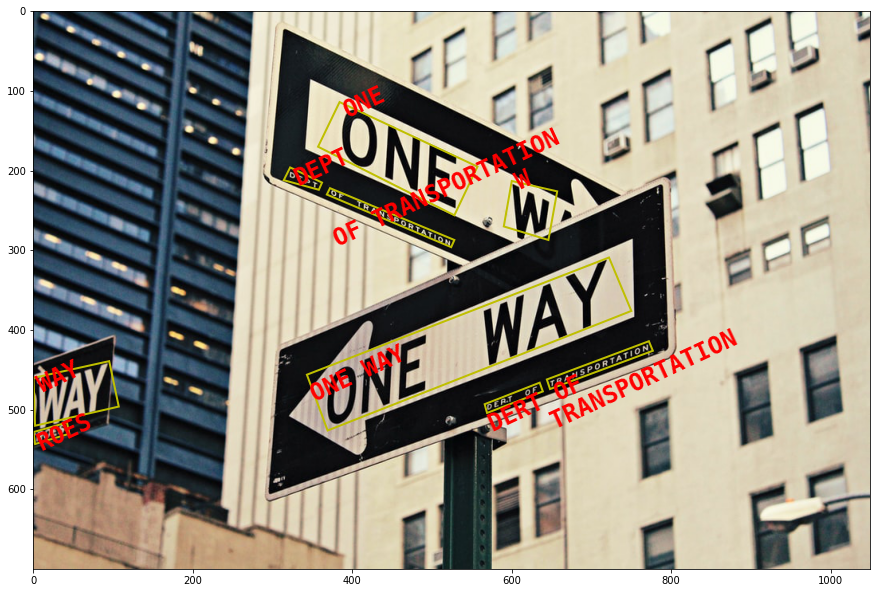

In [47]:
# Render image with predictions
render_text_recognition_image(ocr_result, image_url)

# Use Case Translator

In [48]:
# Helper function to translate text 
def translate_text(translate_urltranslate_key, params, data, json):

  constructed_url = translator_dict['translator_text_API'][0]['url'] + params

  response = requests.request('post', constructed_url, data = data, json=json, headers = translator_dict['translator_text_API'][0]['headers'])
  response.raise_for_status()
  result = response.json()

  return result

'Come'
'We are'
'OPEN'


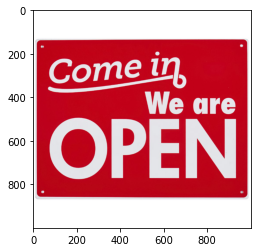

In [49]:
# Step one: Extract text from image

# Set image_url to the URL of an image that you want to recognize.
image_url = "https://s3-ap-southeast-2.amazonaws.com/wc-prod-pim/JPEG_1000x1000/SANMS93_sandleford_open_closed_sign_225_x_300mm.jpg"

json = { 'url': image_url } 
data = None

# Result of text recognitioning
translate_result = text_recognition(text_recognition_dict['text_recognition_API'][0]['url'], 
                                    text_recognition_dict['text_recognition_API'][0]['headers'], 
                                    json, 
                                    data)

# Print to see results
messages = []
for i in translate_result['analyzeResult']['readResults'][0]['lines']:
  messages.append(i['text'])
  pprint(i['text'])
  image = Image.open(BytesIO(requests.get(image_url).content))
  plt.imshow( image )
# print(type(messages))

In [50]:
import json as j

# Convert translation to json
def translation_to_json(result):
  text_to_translate = []

  for i in result['analyzeResult']['readResults'][0]['lines']:
    text_to_translate.append(i['text'])

  convert_to_json = j.dumps(text_to_translate)

  return convert_to_json


In [51]:
# Add text to be translated

# Translate to spanish
params = '&to=de'

data = None

# Translate extracted result
body = [{'text': translation_to_json(translate_result)}]

spanish_result = translate_text(translator_dict['translator_text_API'][0]['_key'], params, data, body)

spanish_result

[{'detectedLanguage': {'language': 'en', 'score': 1.0},
  'translations': [{'text': '["Komm", "Wir sind", "OPEN"]', 'to': 'de'}]}]

In [52]:
# Extract translated text from result
translation = ''
for i in spanish_result[0]['translations']:
  translation = i['text']
  translation = str(translation).strip('[]')
print(translation)

"Komm", "Wir sind", "OPEN"


In [53]:
# Extract translated text from result
translation = []
for i in spanish_result[0]['translations']:

  translation.append(i['text'])
  #translation = str(translation).strip('[]')

translation

['["Komm", "Wir sind", "OPEN"]']

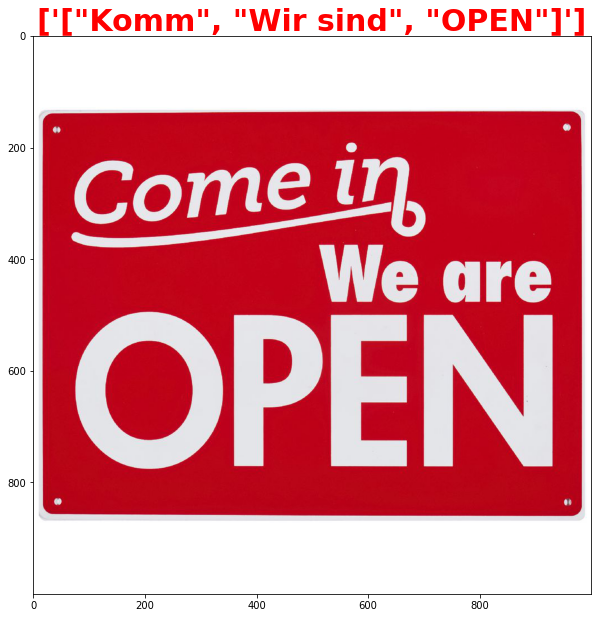

In [54]:
# Render translation on image
render_image(translation, image_url);

# Use Case Sentiment Analysis
Cognitive API for Text Analytics

In [55]:
# # Cognitive API for Text Analytics
def sentiment_analysis(text, language):

  documents = {"documents": [
    {"id": "1", "language": language,
        "text": text}
              ]}
  
  response = requests.post(sentiment_dict['sentiment_analytics_API'][0]['url'], 
                           headers=sentiment_dict['sentiment_analytics_API'][0]['headers'], 
                           json=documents)
  
  sentiment_result = response.json()

  return sentiment_result

In [56]:
def count_score(sentiment_result):
  # The sentiment score for a document is between 0.0 and 1.0, with a higher score indicating a more positive sentiment.
  positive = 0
  negative = 0
  for i in sentiment_result['documents']:
    score = i['score']
    if(score > 0.50):
      positive+=1
    else:
      negative+=1

  print('Positive score: ', positive)
  print('Negative score: ', negative)

In [57]:
# Write an input text and analyze 
text = input('Write you sentence here: ')

# Save result as a variabel
sentiment_result_english = sentiment_analysis(text, 'en')

# See score for positive/negative
count_score(sentiment_result_english)

Write you sentence here: socks are very nice
Positive score:  1
Negative score:  0


In [58]:
# In Spanish
text = "Los caminos que llevan hasta Monte Rainier son espectaculares y hermosos."
# Save result as a variabel
sentiment_result_spanish = sentiment_analysis(text, 'es')

# See output
pprint(sentiment_result_spanish)

{'documents': [{'id': '1', 'score': 0.7456425428390503}], 'errors': []}


# Azure Media Face Detector

In [59]:
# Face Detect API 

# Image to detect
face_detect_image = 'https://upload.wikimedia.org/wikipedia/commons/3/37/Dagestani_man_and_woman.jpg'

json = { 'url': face_detect_image } 
data = None

face_result = processRequest(face_detector_dict['face_detector_API'][0]['url'],
               json,
               data,
               face_detector_dict['face_detector_API'][0]['headers'],
               face_detector_dict['face_detector_API'][0]['params'])

pprint(face_result)

[{'faceAttributes': {'accessories': [],
                     'age': 30.0,
                     'blur': {'blurLevel': 'high', 'value': 0.89},
                     'emotion': {'anger': 0.0,
                                 'contempt': 0.0,
                                 'disgust': 0.0,
                                 'fear': 0.0,
                                 'happiness': 0.0,
                                 'neutral': 0.999,
                                 'sadness': 0.001,
                                 'surprise': 0.0},
                     'exposure': {'exposureLevel': 'goodExposure',
                                  'value': 0.51},
                     'facialHair': {'beard': 0.4,
                                    'moustache': 0.4,
                                    'sideburns': 0.1},
                     'gender': 'male',
                     'glasses': 'NoGlasses',
                     'hair': {'bald': 0.04,
                              'hairColor': [{'color': 'blac

In [60]:
# Save emotion for sentiment analysis
emotion = ''
for i in face_result:
  emotion = i['faceAttributes']['emotion']

# Save results in new list
result_list = []

# Loop through emotion items and append to list
for key, value in emotion.items():
  if(value > 0):
    result = sentiment_analysis(key, 'en')
    result_list.append(result)
    pprint(key)

'contempt'
'happiness'
'neutral'
'sadness'


In [75]:
# Plot sentiment analysis on image

def render_face_sentiment_image(image_url, result):
  
  image = Image.open(BytesIO(requests.get(image_url).content))
  fig, ax = plt.subplots(figsize=(10,10))

  ax.imshow(image, alpha=0.6)

  for face in result:
    fr = face["faceRectangle"]
    fa = face["faceAttributes"]
    origin = (fr["left"], fr["top"])

    rectangle = matplotlib.patches.Rectangle(origin, fr["width"],
                            fr["height"], fill=False, linewidth=2, color='b')
    
    ax.axes.add_patch(rectangle)
    ax.text(origin[0], origin[1], "%s"%(fa["emotion"]),
                fontsize=10, weight="bold", va="bottom")

    ax.axis("off")

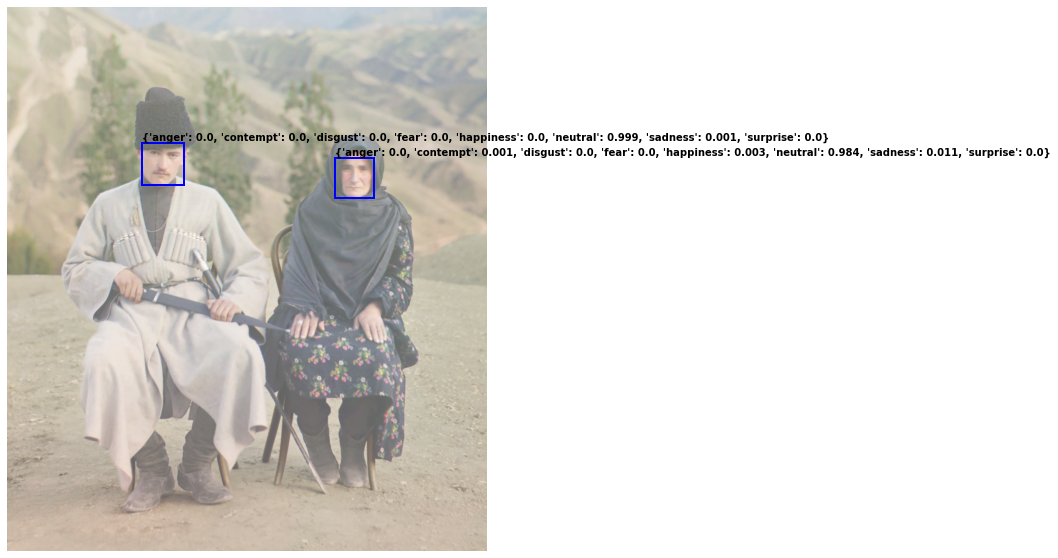

In [76]:
render_face_sentiment_image(face_detect_image, face_result)